## Ising Model GAN 

In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import time
from IPython import display
from model import make_discriminator_model, make_generator_model, generator_loss, discriminator_loss
import csv
from google.colab import drive
drive.mount('/content/drive')
data_path = "drive/MyDrive/Studia/Data/"

2023-11-23 06:54:56.056202: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 06:54:56.857130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 06:54:56.857268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 06:54:56.986029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 06:54:57.267081: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 06:54:57.272084: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Load data

In [2]:
def load_npy_file(file_path):
    return np.load(file_path)

def load_numpy_file_wrapper(file_path):
    return tf.numpy_function(load_npy_file, [file_path], tf.int32)

def dataset_pipeline(path, flatten=True, batch_size=1):
    print("Getting data from " + path)
    data = np.load(path)
    print(f"Got {len(data)} samples")
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    if flatten:
        dataset = dataset.map(lambda x: tf.reshape(x, [batch_size, -1]), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(lambda x: tf.expand_dims(x, 3), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x: tf.cast(x, tf.float32), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


def get_param_dict(path):
    try:
        reader = csv.DictReader(open(f"{path}/parameters.csv"))
        par_dict = next(reader)
    except:
        raise ValueError("Invalid folder provided")
    return par_dict

Getting data from ../../GetData/Python/Data/Trainset
Got 10000 samples
Getting data from ../../GetData/Python/Data/Testset
Got 1000 samples


In [ ]:
trainset_path = f"{data_path}/trainset.npy"
testset_path =  f"{data_path}/testset.npy"
batch_size = 75
train_set = dataset_pipeline(trainset_path, flatten=False, batch_size=batch_size)
test_set = dataset_pipeline(testset_path, flatten=False, batch_size=batch_size)

## Model

In [3]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [4]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Setup training

In [5]:
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])

In [6]:
BATCH_SIZE = 64
def train_step(images, gen_loss_log, disc_loss_log):
      noise = tf.random.normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        gen_loss_log.append(gen_loss)
        disc_loss = discriminator_loss(real_output, generated_output)
        disc_loss_log.append(disc_loss)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [7]:
def generate_and_save_images(model, epoch, test_input):
  predictions = tf.round(model(test_input, training=False))

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [8]:
def train(dataset, epochs, gen_loss_log, disc_loss_log):  
  
  for epoch in range(epochs):
    start = time.time()

    for images in tqdm(dataset): train_step(images, gen_loss_log, disc_loss_log)

    display.clear_output(wait=True) 
    generate_and_save_images(
      generator,
      epoch + 1,
      random_vector_for_generation
    ) 
    print (f"Time taken for epoch {epoch} is {time.time()- start} sec")
  # saving (checkpoint) the model every 15 epochs
  #  if (epoch + 1) % 15 == 0:
  #    checkpoint.save(file_prefix = checkpoint_prefix)

## Train the GAN!

In [9]:
EPOCHS=5
gen_loss_log=[]
disc_loss_log=[]

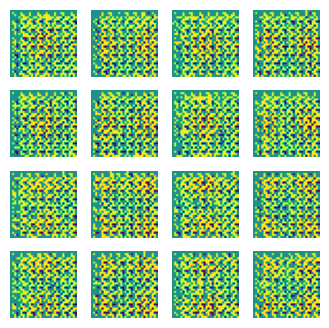

Time taken for epoch 4 is 976.4092659950256 sec
CPU times: user 2h 43min 30s, sys: 6min 56s, total: 2h 50min 26s
Wall time: 1h 19min 25s


In [10]:
%%time
train(train_ds, EPOCHS,gen_loss_log,disc_loss_log)

## Plot the loss of the generator and discriminator

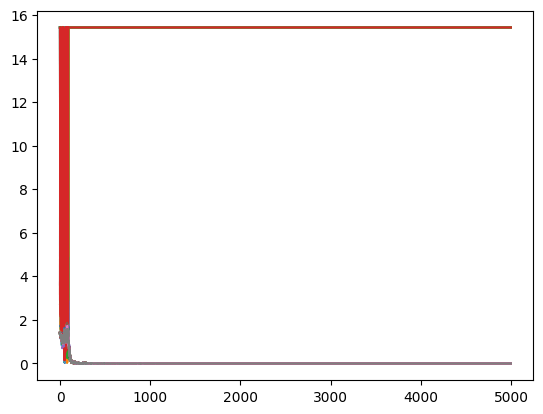

In [11]:
plt.plot(np.asarray(gen_loss_log))
plt.plot(np.asarray(disc_loss_log))

In [13]:
predictions = generator(random_vector_for_generation, training=False)

In [14]:
predictions

<tf.Tensor: shape=(16, 32, 32, 1), dtype=float32, numpy=
array([[[[ 0.00400385],
         [-0.04036747],
         [-0.06245883],
         ...,
         [ 0.44116232],
         [ 0.05725968],
         [ 0.03231147]],

        [[ 0.25623012],
         [ 0.5439842 ],
         [ 0.30523518],
         ...,
         [ 0.980162  ],
         [-0.18612975],
         [-0.42450267]],

        [[ 0.12864707],
         [ 0.256169  ],
         [ 0.5144447 ],
         ...,
         [ 0.83638257],
         [ 0.5335901 ],
         [-0.05823248]],

        ...,

        [[-0.20744708],
         [ 0.8593015 ],
         [-0.614293  ],
         ...,
         [ 0.99896693],
         [-0.69979626],
         [-0.7595079 ]],

        [[-0.11729722],
         [ 0.24859814],
         [ 0.57203823],
         ...,
         [ 0.87877166],
         [ 0.5699363 ],
         [-0.15656722]],

        [[-0.10653971],
         [ 0.03206944],
         [ 0.6418565 ],
         ...,
         [-0.63932973],
         [ 0.737406